참고
- [kaggle 5등](https://www.kaggle.com/code/viktortaran/space-titanic/notebook##5.Modeling)

In [1]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

In [2]:
import pandas as pd

train_update = pd.read_csv('./kaggle/input/spaceship-titanic/train_update.csv')
test_update = pd.read_csv('./kaggle/input/spaceship-titanic/test_update.csv')

# train_update = pd.read_csv('./kaggle/input/spaceship-titanic/train_TotalSpend_update.csv')
# test_update = pd.read_csv('./kaggle/input/spaceship-titanic/test_TotalSpend_update.csv')

In [3]:
train_update.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'TotalSpend', 'Name', 'Transported', 'testset'],
      dtype='object')

In [6]:
features = train_update.drop(['PassengerId','Transported','testset','Name'],axis=1)
labels = train_update['Transported']
X_train, X_test, y_train, y_test=train_test_split(features,labels,test_size=0.3,random_state=42)

In [7]:
# models = [XGBClassifier(),CatBoostClassifier()]
# scores = dict()

# for m in models:
#     m.fit(X_train, y_train)
#     y_pred = m.predict(X_test)

#     print(f'model: {str(m)}')
#     print(f'Accuracy_score: {accuracy_score(y_test,y_pred)}')
#     print(f'Precission_score: {precision_score(y_test,y_pred)}')
#     print(f'Recall_score: {recall_score(y_test,y_pred)}')
#     print(f'F1-score: {f1_score(y_test,y_pred)}')
#     print('-'*30, '\n')

In [8]:
import numpy as np
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    data, target = features,labels
    train_x, valid_x, train_y, valid_y = train_test_split(features,labels, test_size=0.3)


    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 20000),
        'subsample':None,
        'subsample_freq':None,
        'reg_alpha':None,
        'colsample_bytree':None,
        'reg_lambda':None,
    }


    lgbm = LGBMClassifier(**param)

    lgbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = lgbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

### caution
- max depth를 12 이상으로 주지 않는 것이 좋은 이유
The default tree growing strategy in catboost is symmetric trees. If you set depth to 16, then every tree will have 2^16 leaves, which is probably not what you want. It is recommended to use depth up to 10 or 12.

    - [catboost pararmeter training](https://catboost.ai/en/docs/concepts/parameter-tuning)

###
1. 캐글 코드 참고
    - https://www.kaggle.com/code/georgyzubkov/spaceship-eda-catboost-with-optuna
2. 설명 블로그 참고
    - https://ssoonidev.tistory.com/107
3. catboost 주요 개념
    - https://dailyheumsi.tistory.com/136

In [9]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-10 22:35:20,593] A new study created in memory with name: no-name-dbab6cdc-6ac5-4417-9425-4142d8d4b39d
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release

Number of finished trials: 100
Best trial:
  Value: 0.8136503067484663
  Params: 
    lambda_l1: 6.342125218538641
    lambda_l2: 4.952876696165546
    learning_rate: 0.038816386806631235
    num_leaves: 355
    feature_fraction: 0.4085304214789881
    bagging_fraction: 0.4157415989360179
    bagging_freq: 4
    min_child_samples: 6
    n_estimators: 19880
    early_stopping_round: 200


In [10]:
from optuna import visualization
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.head()

Best trial: score 0.8136503067484663,
params {'lambda_l1': 6.342125218538641, 'lambda_l2': 4.952876696165546, 'learning_rate': 0.038816386806631235, 'num_leaves': 355, 'feature_fraction': 0.4085304214789881, 'bagging_fraction': 0.4157415989360179, 'bagging_freq': 4, 'min_child_samples': 6, 'n_estimators': 19880, 'early_stopping_round': 200}


,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_early_stopping_round,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_min_child_samples,params_n_estimators,params_num_leaves,state
0,0,0.796396,2022-12-10 22:35:20.594993,2022-12-10 22:35:21.266164,0 days 00:00:00.671171,0.607647,1,200,0.450087,6.576761,0.208098,0.017014,68,10926,449,COMPLETE
1,1,0.799847,2022-12-10 22:35:21.268169,2022-12-10 22:35:21.617454,0 days 00:00:00.349285,0.799936,1,200,0.686070,4.521460,6.549797,0.066453,62,5765,45,COMPLETE
2,2,0.794095,2022-12-10 22:35:21.619007,2022-12-10 22:35:23.860227,0 days 00:00:02.241220,0.945680,2,200,0.947508,9.409934,7.572977,0.006948,78,6998,55,COMPLETE
3,3,0.789494,2022-12-10 22:35:23.861230,2022-12-10 22:35:24.387500,0 days 00:00:00.526270,0.880053,1,200,0.607932,8.610499,2.757159,0.069870,86,16237,95,COMPLETE
4,4,0.787577,2022-12-10 22:35:24.388502,2022-12-10 22:35:24.608390,0 days 00:00:00.219888,0.571633,1,200,0.536565,0.395909,9.439087,0.084028,30,1813,77,COMPLETE


In [20]:
# optuna.visualization.plot_slice(study)

In [23]:
# optuna.visualization.plot_optimization_history(study)

In [11]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [early_stopping_round (IntDistribution):
                                0.0<extra></extra>, bagging_fraction
                                (FloatDistribution):
                                0.032611977598941876<extra></extra>, lambda_l1
                                (FloatDistribution):
                                0.05770409840310311<extra></extra>, num_leaves
                                (IntDistribution):
                                0.06349789268645102<extra></extra>, bagging_freq
                                (IntDistribution):
                                0.0731394581700177<extra></extra>, n_estimators
                                (IntDistribution):
                                0.07435030171766167<extra></extra>,
                                min_child_samples (IntDistribution):
                                0.09361873243093845<extra></extra>,
                                feature_fraction (FloatDistribution):
                                0.0993000842752956<extra></extra>, lambda_l2
                                (FloatDistribution):
                                0.09969126716912804<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.40608618754846265<extra></extra>],
              'marker': {'color': 'rgb(66,146,198)'},
              'orientation': 'h',
              'text': [<0.01, 0.03, 0.06, 0.06, 0.07, 0.07, 0.09, 0.10, 0.10,
                       0.41],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0, 0.032611977598941876, 0.05770409840310311,
                    0.06349789268645102, 0.0731394581700177, 0.07435030171766167,
                    0.09361873243093845, 0.0993000842752956, 0.09969126716912804,
                    0.40608618754846265],
              'y': [early_stopping_round, bagging_fraction, lambda_l1, num_leaves,
                    bagging_freq, n_estimators, min_child_samples,
                    feature_fraction, lambda_l2, learning_rate]}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Importance for Objective Value'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [10]:
# {'lambda_l1': 6.342125218538641, 'lambda_l2': 4.952876696165546, 'learning_rate': 0.038816386806631235, 
# 'num_leaves': 355, 'feature_fraction': 0.4085304214789881, 'bagging_fraction': 0.4157415989360179, 
# 'bagging_freq': 4, 'min_child_samples': 6, 'n_estimators': 19880}

clf=LGBMClassifier()
parametres={'lambda': [4.765956631322167], 'alpha': [7.278969272081835], 'colsample_bytree': [0.6641875700915917],
'subsample': [0.688162062678529], 'learning_rate': [0.02715737843456302], 'n_estimators': [2865],
'max_depth': [8], 'min_child_weight': [4], 'num_parallel_tree': [1]}
grid_search_cv_clf=GridSearchCV(clf,parametres,cv=5)
grid_search_cv_clf.fit(X_train,y_train)
best_clf2=grid_search_cv_clf.best_estimator_
y_pred2=best_clf2.predict(X_test)
print(f'Accuracy_score: {accuracy_score(y_test,y_pred2)}')

Accuracy_score: 0.7975460122699386


In [18]:
import joblib
model_path = './' + 'model/' + 'optunaXGB' +'.model'
# model.save_model(model_path)
joblib.dump(best_clf2, open(model_path, 'wb'))

Text(0.5, 1.0, 'Feature Importance')

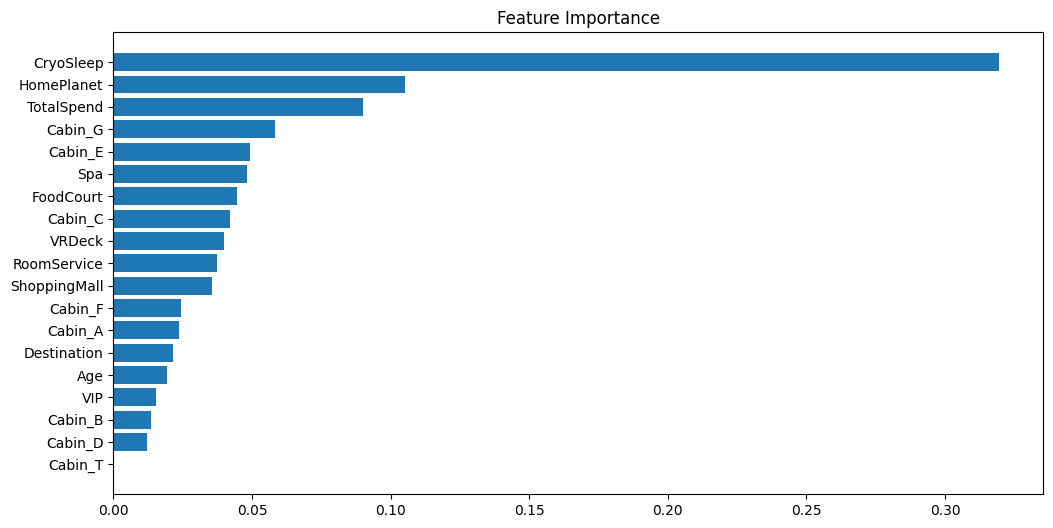

In [11]:
import matplotlib.pyplot as plt

feature_importance = best_clf2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


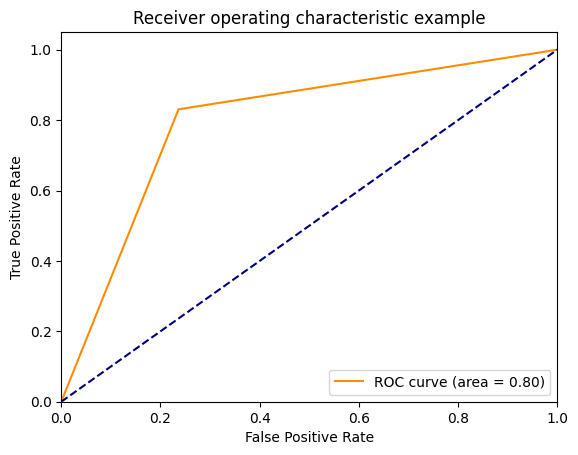

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [13]:
# test_update = pd.read_csv('./kaggle/input/spaceship-titanic/test_AgeGroup_update.csv')
test01 = test_update.drop(['PassengerId','Transported','testset','Name'],axis=1)
y_predicted=best_clf2.predict(test01)

In [14]:
submissions = pd.concat([test_update.PassengerId,pd.Series(y_predicted).map(bool)],axis=1)

In [15]:
# pred = model.predict(test_update.drop(['Transported','testset','Name','PassengerId'],axis=1))

In [16]:
submissions=submissions.rename(columns={0:'Transported'})

In [17]:
submissions.to_csv('submissionXGB.csv',index=False)